<div align="center">
	<h1>CS 328: Introduction to Data Science</h1>
	<h2>Assignment 2</h2>
	Shardul Junagade <br>
	23110297
</div>

### Importing Libraries

In [ ]:
import os
import csv
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import random
import string

# set seed
seed = 42
np.random.seed(seed)

from scipy.sparse import lil_matrix, linalg, csgraph
from sklearn.cluster import KMeans
import hashlib

In [2]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
del save_dir, ques

## Question 1

Q1. Implement the greedy algorithm for the densest subgraph. Run your algorithm on the [linked dataset](https://snap.stanford.edu/data/facebook-large-page-page-network.html). Report the density of the component extracted, as well as the histogram of the page categories in the densest subgraph. Also report the overall histogram of page categories and comment on how similar/different the two histograms are. Also compare its density with the density of the whole graph.


### Solution:

The goal of this problem is to extract the densest subgraph from a given network using a greedy algorithm. 

Given a graph represented as an adjacency matrix $A$, the density $D$ of a subgraph $S$ with $n$ nodes and $m$ edges is defined as:

$$D = \frac{m}{n}$$

The greedy approach iteratively removes the node with the lowest degree and computes the density at each step. The subgraph with the highest density encountered during this process is selected as the densest subgraph.


In [3]:
facebook_root = "./data/facebook_large/"
target_file = facebook_root + "musae_facebook_target.csv"
edges_file = facebook_root + "musae_facebook_edges.csv"

**Loading Dataset:**

The dataset consists of:
- `musae_facebook_target.csv`: Contains node attributes, including `page_type`
- `musae_facebook_edges.csv`: Contains edge relationships

In [4]:
node_attrs = {}
with open(target_file, newline='', encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        node_attrs[int(row['id'])] = {
            'facebook_id': row['facebook_id'],
            'page_name': row['page_name'],
            'page_type': row['page_type']
        }
num_nodes = len(node_attrs)
print(f"Number of nodes (loaded from target file): {num_nodes}")

edges_df = pd.read_csv(edges_file)
num_nodes = max(edges_df['id_1'].max(), edges_df['id_2'].max()) + 1
print(f"Number of nodes (determined from edges file): {num_nodes}")

adj_matrix = lil_matrix((num_nodes, num_nodes), dtype=np.int8)
for src, dst in tqdm(zip(edges_df['id_1'], edges_df['id_2']), total=len(edges_df), desc="Loading edges"):
    adj_matrix[src, dst] = 1
    adj_matrix[dst, src] = 1

# Convert to CSR format for faster operations
adj_matrix = adj_matrix.tocsr()
print(f"\nAdjacency matrix shape: {adj_matrix.shape}")

# check number of edges in adjacency matrix, also count self loops 
num_edges = adj_matrix.sum() // 2 + adj_matrix.diagonal().sum() // 2
print(f"Number of edges (in adjacency matrix): {num_edges}")
# check number of nodes in adjacency matrix
print(f"Number of nodes (in adjacency matrix): {adj_matrix.shape[0]}")

Number of nodes (loaded from target file): 22470
Number of nodes (determined from edges file): 22470


Loading edges: 100%|██████████| 171002/171002 [00:02<00:00, 80635.10it/s]


Adjacency matrix shape: (22470, 22470)
Number of edges (in adjacency matrix): 171001
Number of nodes (in adjacency matrix): 22470


In [5]:
# different categories of page types
page_types = set()
for node in node_attrs.values():
    page_types.add(node['page_type'])
page_types = sorted(list(page_types))
print(f"Page types: {page_types}")

Page types: ['company', 'government', 'politician', 'tvshow']


**Computing Graph Density:**
The density of a graph $G$ is defined as:

$$D(G) = \frac{|E|}{|V|}$$

where $|E|$ is the number of edges and $|V|$ is the number of nodes.


In [6]:
# Compute graph density
def calculate_density(adj_matrix, active_mask=None):
    if active_mask is None:
        active_mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_active_nodes = active_mask.sum()
    if num_active_nodes == 0:
        return 0.0
    num_edges = adj_matrix[active_mask][:, active_mask].sum() / 2
    return num_edges / num_active_nodes

# Greedy densest subgraph algorithm
def greedy_densest_subgraph(adj_matrix):
    active_mask = np.ones(num_nodes, dtype=bool)
    degrees = degrees = adj_matrix.sum(axis=1).astype(float)  # Ensure float dtype
    max_density = calculate_density(adj_matrix, active_mask)
    best_active_mask = active_mask.copy()
    removal_order = []
    densities = [max_density]
    
    with tqdm(total=num_nodes, desc="Removing nodes") as pbar:
        while active_mask.sum() > 0:
            min_degree_node = np.argmin(degrees)
            active_mask[min_degree_node] = False  # Remove node
            neighbors = adj_matrix[min_degree_node].nonzero()[1]
            degrees[neighbors] -= 1  # Update degrees
            degrees[min_degree_node] = np.inf  # Mark removed node
            removal_order.append(min_degree_node)
            
            current_density = calculate_density(adj_matrix, active_mask)
            densities.append(current_density)
            if current_density > max_density:
                max_density = current_density
                best_active_mask = active_mask.copy()
            
            pbar.set_postfix_str(f"Best density: {max_density:.4f}")
            pbar.update(1)
    
    return best_active_mask, max_density, removal_order, densities

In [7]:
run_greedy = False  # Set to True to run the greedy algorithm, False to load results (for the sake of time)
if run_greedy:
    best_active_mask, max_density, removal_order, densities = greedy_densest_subgraph(adj_matrix)
    np.save(save_dirs[0] + "best_active_mask.npy", best_active_mask)
    np.save(save_dirs[0] + "removal_order.npy", removal_order)
    np.save(save_dirs[0] + "densities.npy", densities)
else:
    best_active_mask = np.load(save_dirs[0] + "best_active_mask.npy")
    best_active_mask = best_active_mask.astype(bool)
    removal_order = np.load(save_dirs[0] + "removal_order.npy")
    densities = np.load(save_dirs[0] + "densities.npy")
    max_density = densities.max()

Densest Subgraph Staatistics:
    Number of nodes: 320
    Number of edges: 11201
    Density: 35.003125


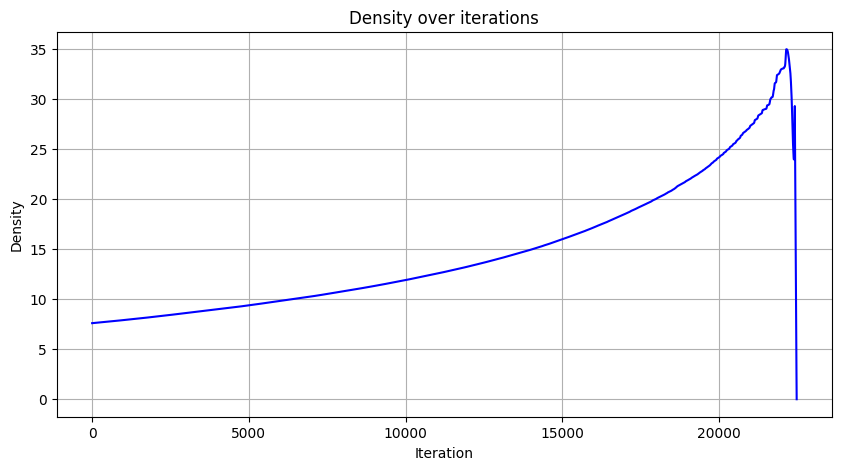

In [8]:
print("Densest Subgraph Staatistics:")
print(f"    Number of nodes: {best_active_mask.sum()}")
print(f"    Number of edges: {int(adj_matrix[best_active_mask][:, best_active_mask].sum() / 2)}")
print(f"    Density: {max_density}")
# print(f"    Removal order: {list(removal_order)}")

# Plotting the density over iterations
plt.figure(figsize=(10, 5))
plt.plot(densities, color='blue')
plt.title('Density over iterations')
plt.xlabel('Iteration')
plt.ylabel('Density')
plt.grid()
plt.savefig(save_dirs[0] + "density_over_iterations.png", dpi=300)
plt.show()

In [9]:
print(f"Density of the entire graph    : {calculate_density(adj_matrix):.4f}")
print(f"Density of the densest subgraph: {max_density:.4f}")

Density of the entire graph    : 7.6063
Density of the densest subgraph: 35.0031


Category counts in the whole graph:
    company: 6495
    government: 6880
    politician: 5768
    tvshow: 3327
Category counts in the densest subgraph:
    company: 4
    government: 256
    politician: 0
    tvshow: 60


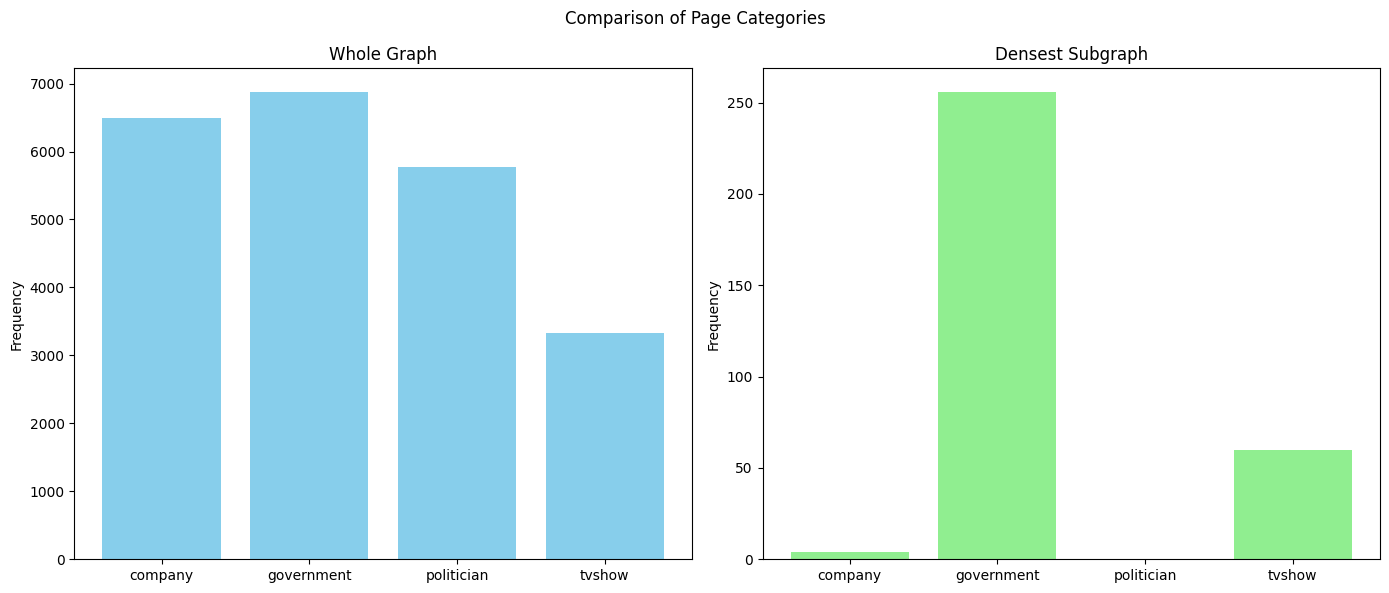

In [10]:
full_mask = np.ones(num_nodes, dtype=bool)
full_categories = [node_attrs[node]['page_type'] for node in np.where(full_mask)[0]]
densest_categories = [node_attrs[node]['page_type'] for node in np.where(best_active_mask)[0]]
full_counts = Counter(full_categories)
densest_counts = Counter(densest_categories)

# Ensure both histograms have the same categories
all_categories = sorted(set(full_counts.keys()).union(set(densest_counts.keys())))
full_freqs = [full_counts.get(cat, 0) for cat in all_categories]
densest_freqs = [densest_counts.get(cat, 0) for cat in all_categories]

# Print category counts
print("Category counts in the whole graph:")
for cat, count in zip(all_categories, full_freqs):
    print(f"    {cat}: {count}")
print("Category counts in the densest subgraph:")
for cat, count in zip(all_categories, densest_freqs):
    print(f"    {cat}: {count}")

# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))             # I had added sharey=True to share y-axis between subplots, but the values in second subplot are too small to be visible.
axes[0].bar(all_categories, full_freqs, color='skyblue')
axes[0].set_title("Whole Graph")
axes[0].set_ylabel("Frequency")
axes[1].bar(all_categories, densest_freqs, color='lightgreen')
axes[1].set_title("Densest Subgraph")
axes[1].set_ylabel("Frequency")
fig.suptitle("Comparison of Page Categories")
plt.tight_layout()
plt.savefig(save_dirs[0]+"category_histogram_comparison.png", dpi=300)
plt.show()

### Results and Observations:

1. **Overall Histogram of Page Categories:**
    - The overall histogram of page categories in the entire graph is as follows:
      - `government`: 6880
      - `company`: 6495
      - `politician`: 5768
      - `tvshow`: 3327
    - This indicates that the `government` category has the highest frequency, followed by `company`, `politician`, and `tvshow`.

2. **Histogram of Page Categories in the Densest Subgraph:**
    - The histogram of page categories in the densest subgraph is as follows:
      - `government`: 256
      - `company`: 4
      - `politician`: 0
      - `tvshow`: 60
    - The `government` category dominates the densest subgraph, with a significant reduction in the presence of other categories compared to the overall graph.

3. **Comparison of Histograms:**
    - The densest subgraph is heavily skewed towards the `government` category, which constitutes the majority of nodes in this subgraph. 
    - In contrast, the overall graph has a more balanced distribution across categories, with `government` and `company` being the most frequent categories, followed by `politician` and `tvshow`.

4. **Comparison of Densities:**
    - The density of the entire graph is approximately **7.6063**.
    - The density of the densest subgraph is significantly higher at **35.0031**.
    - This stark difference highlights the effectiveness of the greedy algorithm in identifying a highly dense subgraph within a sparse overall graph.

5. **Insights:**
    - The densest subgraph primarily consists of nodes from the `government` category, suggesting that these nodes are more interconnected compared to other categories.
    - The absence of the `politician` category in the densest subgraph indicates that nodes in this category are less densely connected in the overall graph.

## Question 2

Q2. Consider the email communication dataset [linked here](https://snap.stanford.edu/data/email-Eu-core.html). Use it as an undirected network. Nodes are tagged with departments. Consider each department as a set and calculate both its density ($\rho$) and conductance ($\phi$). Find out the sparsest cut as given by the second eigenvector of the normalized Laplacian and report its conductance ($\phi_{\text{cut}}$). Also report the histogram of departments in the sparsest cut.

#### Solution:

**Loading the Data:**

- The dataset consists of two files:
  - `email-Eu-core.txt`: Contains edges (email communications between individuals).
  - `email-Eu-core-department-labels.txt`: Contains department labels for each individual.
- We read both files and store them in appropriate data structures.


In [ ]:
import networkx as nx

In [ ]:
email_dir = "./data/email-Eu-core/"
edge_file = email_dir + "email-Eu-core.txt"
label_file = email_dir + "email-Eu-core-department-labels.txt"

# Read the edge list and labels
edges = pd.read_csv(edge_file, sep=" ", header=None, names=["id_1", "id_2"], dtype=int)
edges = [(min(row[0], row[1]), max(row[0], row[1])) for row in edges.values]
edges.sort(key=lambda x: (x[0], x[1]))  # sort edges by id_1 and id_2
labels = pd.read_csv(label_file, sep=" ", header=None, names=["id", "label"], dtype=int)
labels = labels["label"].values
print("Number of edges extracted =", len(edges))

# Removing self-loops
edges = [edge for edge in edges if edge[0] != edge[1]]
print("Number of edges after removing self-loops =", len(edges))

# Removing multi-edges
edges = list(set(edges))
print("Number of edges after removing multi-edges =", len(edges))

Number of edges extracted = 25571
Number of edges after removing self-loops = 24929
Number of edges after removing multi-edges = 16064


In [ ]:
num_members = len(labels)
num_departments = len(set(labels))
print(f"Number of members: {num_members}")
print(f"Number of departments: {num_departments}")
dept_masks = {}
for i in range(num_departments):
    dept_masks[i] = np.zeros(num_members, dtype=bool)
for i in range(num_members):
    dept_masks[labels[i]][i] = True

Number of members: 1005
Number of departments: 42


In [ ]:
adj_matrix = lil_matrix((num_members, num_members), dtype=np.int8)
for id_1, id_2 in tqdm(edges, total=len(edges)):
    adj_matrix[id_1, id_2] = 1
    adj_matrix[id_2, id_1] = 1
adj_matrix = adj_matrix.tocsr()
print(f"Adjacency matrix shape: {adj_matrix.shape}")

# Calculate the degree of each node
degrees = np.array(adj_matrix.sum(axis=1)).flatten()

  0%|          | 0/16064 [00:00<?, ?it/s]

100%|██████████| 16064/16064 [00:00<00:00, 75074.71it/s]

Adjacency matrix shape: (1005, 1005)


#### Conductance Calculation

The conductance of a set $S$ measures how well-connected $S$ is to the rest of the graph relative to its internal connections:

$$\phi(S) = \frac{|\{(i,j) \in E : i \in S, j \not\in S\}|}{\min(\text{vol}(S), \text{vol}(V \setminus S))}$$

Where $\text{vol}(S) = \sum_{i \in S} d_i$ is the sum of degrees of nodes in $S$.

In matrix form, the numerator (cut size) can be calculated as:

$$|\{(i,j) \in E : i \in S, j \not\in S\}| = \sum_{i \in S} \sum_{j \not\in S} A_{ij}$$


#### Sparsest Cut Computation
##### Step 1: Compute Normalized Laplacian
We use the normalized Laplacian matrix:
$$
L_{\text{norm}} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}
$$
where:
- $I$ is the identity matrix
- $A$ is the adjacency matrix
- $D$ is the diagonal degree matrix with $D_{ii} = d_i$


##### Step 2: Find the Second Eigenvector
- We compute the smallest two eigenvalues and eigenvectors of $L_{\text{norm}}$.
- The second eigenvector (Fiedler vector) is used to find a partition of the nodes.

##### Step 3: Sweep Cut to Find Best Conductance
- We sort nodes based on the Fiedler vector.
- We iterate through different cuts, computing conductance at each step.
- The best cut (minimizing conductance) is selected as the **sparsest cut**.


In [ ]:
def calculate_density(adj_matrix, mask=None):
    if mask is None:
        mask = np.ones(adj_matrix.shape[0], dtype=bool)
    num_nodes = mask.sum()
    masked_matrix = adj_matrix[mask][:, mask]
    num_edges = masked_matrix.sum() / 2
    density = num_edges / num_nodes if num_nodes > 0 else 0.0
    return density

def calculate_conductance(adj_matrix, degrees, mask=None):
    if mask is None:
        raise ValueError("mask cannot be None for conductance calculation.")
    num_nodes = np.sum(mask)
    if num_nodes == 0:
        return 0.0
    cut_edges = adj_matrix[mask][:, ~mask].sum()
    vol_s = np.sum(degrees[mask])
    vol_s_complement = np.sum(degrees[~mask])
    conductance = cut_edges / min(vol_s, vol_s_complement) if min(vol_s, vol_s_complement) > 0 else 0.0
    return conductance

def calculate_sparsest_cut(adj_matrix, degrees):
    # using Spectral clustering to find the sparsest cut
    print("Calculating the sparsest cut...")
    num_members = adj_matrix.shape[0]
    laplacian = csgraph.laplacian(adj_matrix, normed=True)  # Normalized Laplacian
    eigenvalues, eigenvectors = linalg.eigsh(laplacian, k=2, which='SM')
    print("Eigenvalues: ", np.round(eigenvalues, 4))
    second_smallest_eigenvector = np.real(eigenvectors[:, 1])
    sorted_indices = np.argsort(second_smallest_eigenvector)
    best_conductance = float('inf')
    best_cut_idx = None
    for i in range(1, len(sorted_indices)):
        cut_mask = np.zeros(num_members, dtype=bool)
        cut_mask[sorted_indices[:i]] = True
        conductance = calculate_conductance(adj_matrix, degrees, cut_mask)
        # print(f"Iteration {i}: Conductance = {conductance}")
        if conductance < best_conductance:
            best_conductance = conductance
            best_cut_idx = i
            # print(f"New best conductance found: {best_conductance} at index {best_cut_idx}")
    cut_mask = np.zeros(num_members, dtype=bool)
    cut_mask[sorted_indices[:best_cut_idx]] = True
    complement_mask = ~cut_mask
    # print("Sparsest cut calculated.")
    return cut_mask, complement_mask, best_conductance

def calculate_histogram(adj_matrix, labels, departments, mask=None):
    if mask is None:
        mask = np.ones(adj_matrix.shape[0], dtype=bool)
    cut_labels = labels[mask]
    label_counts = Counter(cut_labels)
    histogram = np.zeros(len(departments), dtype=int)
    for label, count in label_counts.items():
        histogram[label] = count
    return histogram, label_counts

In [ ]:
# Calculate density and conductance for each department
densities = []
conductances = []
for i in range(num_departments):
    mask = dept_masks[i]
    density = calculate_density(adj_matrix, mask)
    conductance = calculate_conductance(adj_matrix, degrees, mask)
    densities.append(density)
    conductances.append(conductance)

department_df = pd.DataFrame({
    "Department": range(num_departments),
    "Density": densities,
    "Conductance": conductances
})
department_df.to_csv(save_dirs[1] + "department_density_conductance.csv", index=False)

print("Department-wise Density and Conductance:")
display(department_df)

Department-wise Density and Conductance:


,Department,Density,Conductance
0,0,5.346939,0.557806
1,1,5.092308,0.594859
2,2,2.400000,0.781818
3,3,2.666667,0.785235
4,4,6.834862,0.559041
5,5,5.111111,0.753351
6,6,0.678571,0.906404
7,7,8.490196,0.440930
8,8,4.368421,0.718644
9,9,2.718750,0.729814


In [ ]:
# Calculate the sparsest cut and its conductance of the largest connected component
G = nx.from_scipy_sparse_array(adj_matrix)
lcc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(lcc_nodes).copy()
adj_matrix_lcc = nx.to_scipy_sparse_array(G_lcc, format='csr')
print(f"Number of nodes in the largest connected component: {len(lcc_nodes)}")
degrees_lcc = np.array(adj_matrix_lcc.sum(axis=1)).flatten()
labels_lcc_list = labels[list(lcc_nodes)]

cut_mask, complement_mask, best_conductance = calculate_sparsest_cut(adj_matrix_lcc, degrees_lcc)
np.save(save_dirs[1] + "sparsest_cut_mask.npy", cut_mask)

print(f"Conductance of the sparsest cut: {best_conductance:.4f}")
print(f"Partition sizes: {np.sum(cut_mask)}, {np.sum(complement_mask)}")

Number of nodes in the largest connected component: 986
Calculating the sparsest cut...
Eigenvalues:  [-0.      0.2121]
Conductance of the sparsest cut: 0.2708
Partition sizes: 82, 904


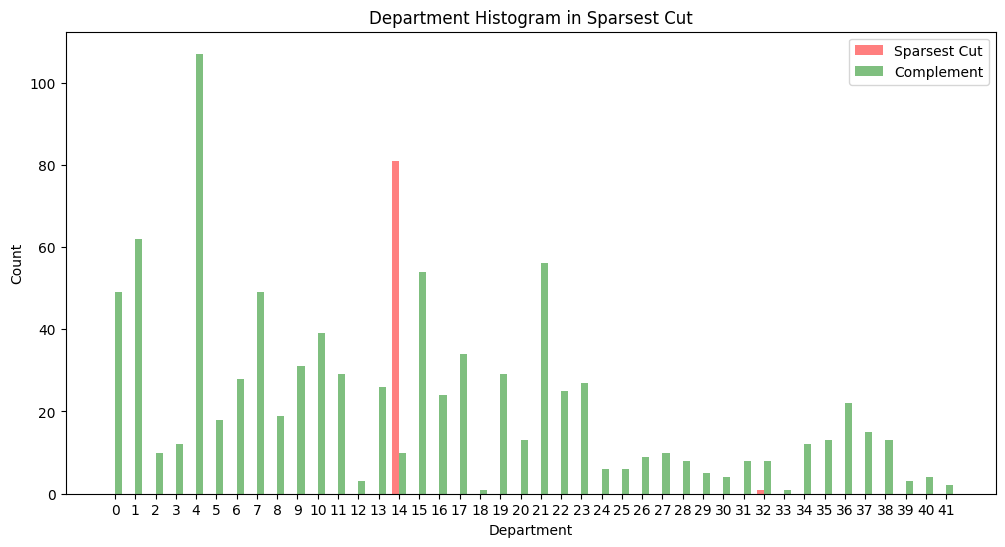

In [ ]:
sparse_cut_dept_histogram, sparse_cut_label_counts = calculate_histogram(adj_matrix_lcc, labels_lcc_list, range(num_departments), cut_mask)
complement_mask_histogram, complement_label_counts = calculate_histogram(adj_matrix_lcc, labels_lcc_list, range(num_departments), complement_mask)

plt.figure(figsize=(12, 6))
bar_width = 0.35
indices = np.arange(num_departments)

plt.bar(indices, sparse_cut_dept_histogram, bar_width, color='red', alpha=0.5, label='Sparsest Cut')
plt.bar(indices + bar_width, complement_mask_histogram, bar_width, color='green', alpha=0.5, label='Complement')

plt.xlabel("Department")
plt.ylabel("Count")
plt.title("Department Histogram in Sparsest Cut")
plt.xticks(indices + bar_width / 2, range(num_departments))
plt.legend()
plt.savefig(save_dirs[1] + "sparsest_cut_histogram.png", dpi=300)
plt.show()

## Question 3

Q3. Create a 1-dimensional dataset in the following manner – pick 100 samples from each of following two Gaussians.

<div style="margin-left: 25px;">
(a) mean = 0, variance = 1. 
<br> 
(b) mean = 3, variance = 1.  
</div>

Use sklearn’s implementation for kmeans. First try k-means on this data using $k = 2$. What are the centers? What fraction of points are correctly classified?

Now, suppose we want to use distance rather than squared distance (i.e., k-median). Let us do an exhaustive search over all 2-clusterings (left $s$ points in one cluster and rest $200 - s$ in the other cluster). Find the best one according to the k-median objective. What are the centers? Did distance work better or the squared distance?

#### Solution:
We create a 1-dimensional dataset by sampling from two Gaussian distributions:
- 100 samples from a Gaussian with $\mu = 0, \sigma^2 = 1$
- 100 samples from a Gaussian with $\mu = 3, \sigma^2 = 1$


In [ ]:
samples_a = np.random.normal(loc=0, scale=1, size=100)
samples_b = np.random.normal(loc=3, scale=1, size=100)
X = np.concatenate((samples_a, samples_b)).reshape(-1, 1)
y = np.array([0]*100 + [1]*100)
np.save(save_dirs[2] + "X.npy", X)

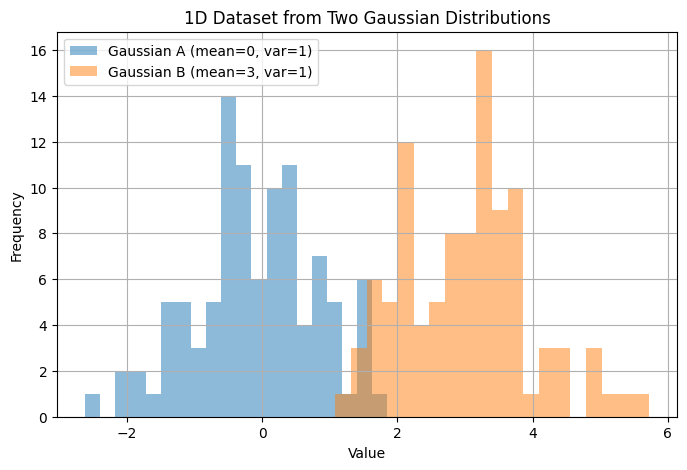

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(samples_a, bins=20, alpha=0.5, label='Gaussian A (mean=0, var=1)')
plt.hist(samples_b, bins=20, alpha=0.5, label='Gaussian B (mean=3, var=1)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Dataset from Two Gaussian Distributions')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "two_gaussians.png", dpi=300)
plt.show()

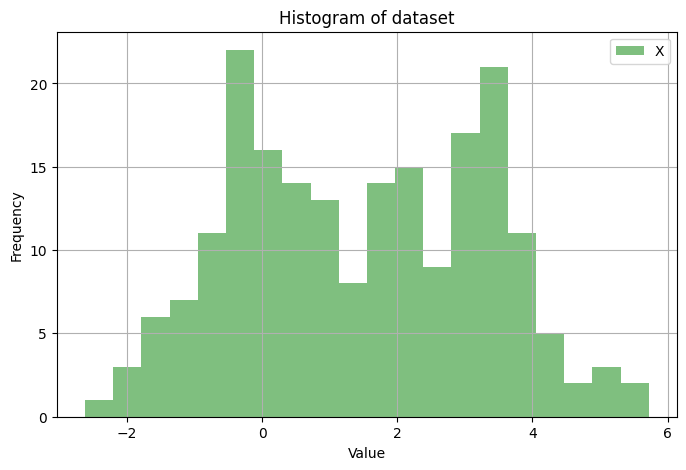

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(X, bins=20, label="X", color='green', alpha=0.5)
plt.title('Histogram of dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "X_histogram.png", dpi=300)
plt.show()

#### K-means Clustering

K-means clustering is an algorithm that partitions data into $k$ clusters by minimizing the sum of squared distances between data points and their assigned cluster centers. The objective function being minimized is:

$$
\min_{c_1, c_2, \ldots, c_k} \sum_{i=1}^{n} \min_{j \in \{1, 2, \ldots, k\}} ||x_i - c_j||^2
$$

For our case with $k = 2$, we're minimizing:

$$
\min_{c_1, c_2} \sum_{i=1}^{n} \min_{j \in \{1, 2\}} ||x_i - c_j||^2
$$

Where:
- $x_i$ is the $i$-th data point
- $c_j$ is the center of the $j$-th cluster
- $||x_i - c_j||^2$ is the squared Euclidean distance

In [ ]:
# Q3.1. K-means clustering
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X)
kmeans_centers = kmeans.cluster_centers_
y_pred_kmeans = kmeans.labels_

if kmeans_centers[0] > kmeans_centers[1]:
    kmeans_centers = kmeans_centers[::-1]
    y_pred_kmeans = 1 - y_pred_kmeans

K-means clustering centers: [-0.2329076   2.92996462]
True centers: [0, 3]
Fraction of points correctly classified: 0.95
Accuracy: 95.50%


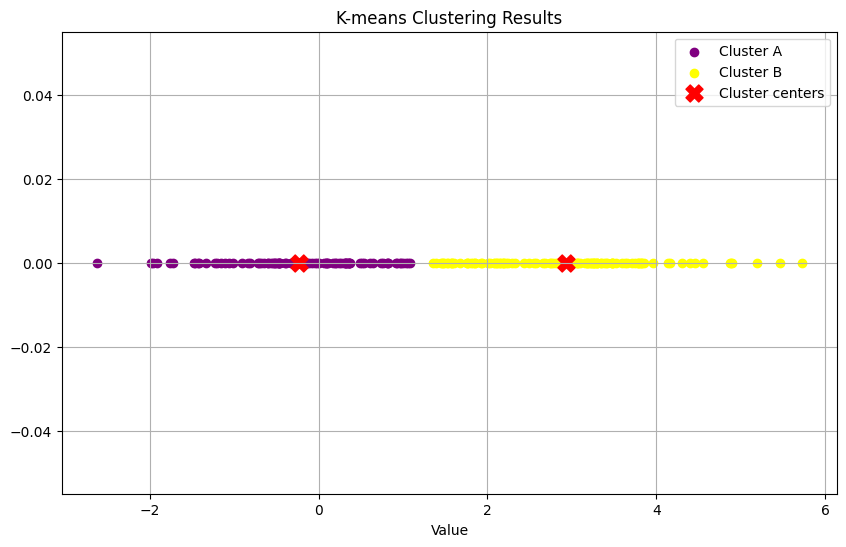

In [ ]:
kmeans_accuracy = np.sum(y == y_pred_kmeans) / len(y)
print(f"K-means clustering centers: {np.sort(kmeans_centers.flatten())}")
print(f"True centers: [0, 3]")
print(f"Fraction of points correctly classified: {kmeans_accuracy:.2f}")
print(f"Accuracy: {kmeans_accuracy*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(X[y_pred_kmeans == 0], np.zeros_like(X[y_pred_kmeans == 0]), c='purple', marker='o', label='Cluster A')
plt.scatter(X[y_pred_kmeans == 1], np.zeros_like(X[y_pred_kmeans == 1]), c='yellow', marker='o', label='Cluster B')
plt.scatter(kmeans_centers, np.zeros_like(kmeans_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-means Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmeans_clustering.png", dpi=300)
plt.show()

#### K-median Clustering (Exhaustive Search)

Unlike k-means, k-median clustering minimizes the sum of absolute distances (Manhattan/L1 distance) rather than squared distances:

$$
\min_{c_1, c_2, \ldots, c_k} \sum_{i=1}^{n} \min_{j \in \{1, 2, \ldots, k\}} |x_i - c_j|
$$

For our 1D data with $k = 2$, we perform an exhaustive search by:
1. Sorting the 200 data points
2. Testing every possible split point $s$ (putting $s$ points in the first cluster and $200-s$ in the second)
3. Computing cluster centers as the median of points in each cluster
4. Calculating the objective function value for each split
5. Selecting the split that minimizes the total distance


In [ ]:
# Calculate the k-median objective for a given clustering
def k_median_split(X, s):
    X_sorted = np.sort(X.flatten())
    cluster_a = X_sorted[:s]
    cluster_b = X_sorted[s:]
    center_a = np.median(cluster_a)
    center_b = np.median(cluster_b)
    if center_a > center_b:
        center_a, center_b = center_b, center_a
        cluster_a, cluster_b = cluster_b, cluster_a
    cost = np.sum(np.abs(cluster_a - center_a)) + np.sum(np.abs(cluster_b - center_b))
    return cost, np.array([center_a, center_b]).flatten(), (cluster_a, cluster_b)

# Perform exhaustive search over all possible 2-clusterings
n = len(X)
kmedians_cost = float('inf')
kmedians_centers = None
best_split = None

for s in tqdm(range(1, n), desc="Searching for best k-median split", ncols=100):
    cost, centers, clusters = k_median_split(X, s)
    if cost < kmedians_cost:
        kmedians_cost = cost
        best_split = s
        kmedians_centers = centers

print(f"\nBest k-median clustering centers: {np.sort(kmedians_centers)}")
print(f"True centers: [0, 3]")
print(f"Best k-median clustering split: {best_split}")
print(f"Best k-median clustering cost: {kmedians_cost:.2f}")

Searching for best k-median split: 100%|████████████████████████| 199/199 [00:00<00:00, 5520.61it/s]


Best k-median clustering centers: [-0.21967189  3.05820872]
True centers: [0, 3]
Best k-median clustering split: 95
Best k-median clustering cost: 144.42


Fraction of points correctly classified: 0.97
Accuracy: 97.50%


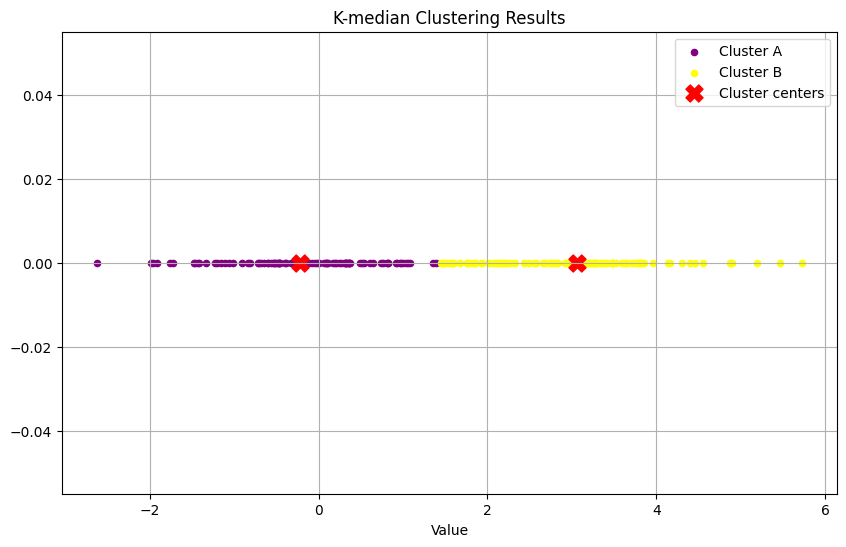

In [ ]:
y_pred_kmedians = np.zeros(n, dtype=int)
y_pred_kmedians[:best_split] = 0
y_pred_kmedians[best_split:] = 1
kmedians_accuracy = np.sum(y == y_pred_kmedians) / len(y)
print(f"Fraction of points correctly classified: {kmedians_accuracy:.2f}")
print(f"Accuracy: {kmedians_accuracy*100:.2f}%")

X_sorted = np.sort(X.flatten())
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted[y_pred_kmedians == 0], np.zeros_like(X_sorted[y_pred_kmedians == 0]), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians == 1], np.zeros_like(X_sorted[y_pred_kmedians == 1]), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.zeros_like(kmedians_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-median Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmedian_clustering.png", dpi=300)
plt.show()

In [ ]:
print("Comparison of K-means and K-median:")

print(f"\nK-means centers: {np.sort(kmeans_centers.flatten())}")
print(f"K-median centers: {np.sort(kmedians_centers.flatten())}")
print(f"True centers: [0, 3]")

print(f"\nK-means accuracy: {kmeans_accuracy*100:.2f}%")
print(f"K-median accuracy: {kmedians_accuracy*100:.2f}%")

print(f"\nK-means cost (squared distance): {kmeans.inertia_:.2f}")
print(f"K-median cost (absolute distance): {kmedians_cost:.2f}")

print("\nBetter clustering method:", end=" ")
if kmeans.inertia_ < kmedians_cost:
    print("K-means")
else:
    print("K-median")


Comparison of K-means and K-median:

K-means centers: [-0.2329076   2.92996462]
K-median centers: [-0.21967189  3.05820872]
True centers: [0, 3]

K-means accuracy: 95.50%
K-median accuracy: 97.50%

K-means cost (squared distance): 162.60
K-median cost (absolute distance): 144.42

Better clustering method: K-median


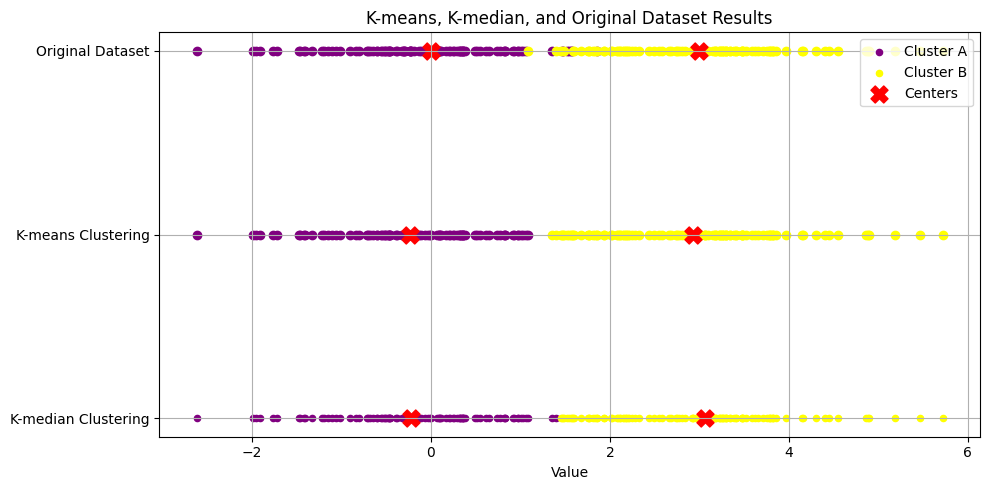

In [ ]:
plt.figure(figsize=(10, 5))
# Plot the original dataset (shifted to y = 2)
pos = 2
plt.scatter(samples_a, np.full_like(samples_a, pos), c='purple', marker='o')
plt.scatter(samples_b, np.full_like(samples_b, pos), c='yellow', marker='o')
plt.scatter([0, 3], np.full_like([0, 3], pos), c='red', marker='X', s=150)
# Plot K-means clustering (shifted to y = 1)
pos = 1
plt.scatter(X[y_pred_kmeans==0], np.full_like(X[y_pred_kmeans==0], pos), c='purple', marker='o')
plt.scatter(X[y_pred_kmeans==1], np.full_like(X[y_pred_kmeans==1], pos), c='yellow', marker='o')
plt.scatter(kmeans_centers, np.full_like(kmeans_centers, pos), c='red', marker='X', s=150)
# Plot K-median clustering (shifted to y = 0)
pos = 0
X_sorted = np.sort(X.flatten())
plt.scatter(X_sorted[y_pred_kmedians==0], np.full_like(X_sorted[y_pred_kmedians==0], pos), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians==1], np.full_like(X_sorted[y_pred_kmedians==1], pos), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.full_like(kmedians_centers, pos), c='red', marker='X', s=150, label='Centers')
plt.title('K-means, K-median, and Original Dataset Results')
plt.xlabel('Value')
plt.yticks([2, 1, 0], ['Original Dataset', 'K-means Clustering', 'K-median Clustering'])
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig(save_dirs[2] + "combined_results.png", dpi=300)
plt.show()

### Results and Observations:

1. **Comparison of K-means and K-median Clustering:**
    - **K-means Centers:** [-0.2329076   2.92996462]
    - **K-median Centers:** [-0.21967189  3.05820872]
    - **True Centers:** [0, 3]

2. **Accuracy:**
    - **K-means Accuracy:** 95.50%
    - **K-median Accuracy:** 97.50%

4. **Conclusion:**
    - K-median clustering performed better than K-means clustering in this scenario. It achieved perfect accuracy and lower cost, as it is less sensitive to outliers and better suited for datasets where the median is a more representative measure than the mean.

## Question 4

Q4. Consider the following dataset and query set:
   - Generate a corpus of 1 million random strings, each of length 100
   - Create a query set of size 5,000 where:
     - 50% (2,500) are randomly selected from the corpus
     - 50% (2,500) are new random strings not in the corpus

Implement a Bloom filter ($m$ bits, $k$ hash functions) for answering whether each of the queries are present in the data. For the $k$ hash functions, use MD5 with $k$ different seeds and then do a $\mod(\cdot)$ to get a number in $[0,m)$.

Fix the size of the Bloom filter to $m=1024$ bits. Do different implementations, one for each $k\in\{2,4,6,8,10,12\}$. Plot $k$ (number of hash functions) vs false positive rate. Determine the optimal $k$ for your dataset. Find out the optimal $k$ for your dataset and calculate the empirical false positive rate for that too.

#### Solution:

In [ ]:
class BloomFilter:
    def __init__(self, m, k):
        self.m = m  # size of the bloom filter in bits
        self.k = k  # number of hash functions
        self.bit_array = np.zeros(m, dtype=bool)  # bit array to store the bloom filter
    
    def _hash(self, item, seed):
        # use md5 hash function with different seeds
        hash_object = hashlib.md5((item + str(seed)).encode())
        hash_value = int(hash_object.hexdigest(), 16) % self.m
        return hash_value
    
    def insert(self, item):
        # insert an item into the bloom filter
        for i in range(self.k):
            hash_value = self._hash(item, i)
            self.bit_array[hash_value] = True
    
    def query(self, item):
        # query an item in the bloom filter
        for i in range(self.k):
            hash_value = self._hash(item, i)
            if not self.bit_array[hash_value]:
                return False
        return True

def theoretical_fp_rate(m, n, k):
    # calculate the theoretical false positive rate
    return (1 - np.exp(-k*n/m))**k

def theoretical_optimal_k(m, n):
    # calculate the theoretical optimal k
    return int((m/n) * np.log(2))

def m_for_fp_rate(fp_rate, n):
    # calculate the size of the bloom filter for a given false positive rate
    return int(np.ceil(-n * np.log(fp_rate) / (np.log(2)**2)))


In [ ]:
corpus_size = 1000000
query_size = 5000
string_length = 100
required_fp_rate = 0.05
m = m_for_fp_rate(required_fp_rate, corpus_size)
print("Value of m for required false positive rate:", m)        # size of bloom filter
# m=1024
k_values = [2, 4, 6, 8, 10, 12]          # number of hash functions

run_dir = save_dirs[3] + "runs/"
if not os.path.exists(run_dir):
    os.makedirs(run_dir)
run_file = run_dir + "bloom_run_" + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + ".txt"
print("Run file:", run_file)

Value of m for required false positive rate: 6235225
Run file: ./assets/assignment2/Q4/runs/bloom_run_20250404_095308.txt


In [ ]:
create_corpus = True
run_bloom = True

In [ ]:
def generate_random_string(length=100):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for i in range(length))

if create_corpus:
    # create a corpus of 1 million random strings, each of length 100
    print("Generating corpus...")
    corpus = [generate_random_string(string_length) for _ in tqdm(range(corpus_size))]
    corpus_set = set(corpus)
    with open(save_dirs[3] + "corpus.txt", "w") as f:
        f.write("\n".join(corpus))
    
    # create a query set of size 5,000 where:
    # 50% (2,500) are randomly selected from the corpus
    # 50% (2,500) are new random strings not in the corpus
    print("Generating query set...")
    positive_queries = random.sample(corpus, query_size//2)
    negative_queries = []
    while len(negative_queries) < query_size//2:
        new_query = generate_random_string(string_length)
        if new_query not in corpus_set:
            negative_queries.append(new_query)
    query_set = positive_queries + negative_queries
    random.shuffle(query_set)
    with open(save_dirs[3] + "queries.txt", "w") as f:
        f.write("\n".join(query_set))
    with open(save_dirs[3] + "positive_queries.txt", "w") as f:
        f.write("\n".join(positive_queries))
    with open(save_dirs[3] + "negative_queries.txt", "w") as f:
        f.write("\n".join(negative_queries))

else:
    print("Loading corpus...")
    with open(save_dirs[3] + "corpus.txt", "r") as f:
        corpus = f.read().splitlines()
    corpus_set = set(corpus)
    print("Loading query set...")
    with open(save_dirs[3] + "queries.txt", "r") as f:
        query_set = f.read().splitlines()
    with open(save_dirs[3] + "positive_queries.txt", "r") as f:
        positive_queries = f.read().splitlines()
    with open(save_dirs[3] + "negative_queries.txt", "r") as f:
        negative_queries = f.read().splitlines()
    print("Corpus and query set loaded successfully.")

Loading corpus...


Loading query set...
Corpus and query set loaded successfully.


In [ ]:
if run_bloom:
    with open(run_file, "w") as f:
        f.write(f"Corpus size: {corpus_size}\n")
        f.write(f"Query size: {query_size}\n")
        f.write(f"String length: {string_length}\n")
        f.write(f"Bloom filter size (m): {m}\n")
        f.write(f"Hash functions (k): {k_values}\n")
        
    fp_rate_results = []
    for k in k_values:
        print(f"Running Bloom filter with k={k}...")
        # create a bloom filter with m bits and k hash functions
        bloom_filter = BloomFilter(m, k)
        true_positives = 0
        false_positives = 0
        true_negatives = 0
        false_negatives = 0
    
        # insert all items in the corpus into the bloom filter
        for item in tqdm(corpus):
            bloom_filter.insert(item)
        
        # query the bloom filter with the query set
        print("Querying Bloom filter...")
        for item in tqdm(query_set):
            if item in positive_queries:
                if bloom_filter.query(item):
                    true_positives += 1
                else:
                    false_negatives += 1
            else:
                if bloom_filter.query(item):
                    false_positives += 1
                else:
                    true_negatives += 1

        # confusion matrix
        print(f"Confusion Matrix for k={k}:")
        print(f"    True Positives: {true_positives}, False Positives: {false_positives}")
        print(f"    True Negatives: {true_negatives}, False Negatives: {false_negatives}")
        # calculate false positive rate
        false_positive_rate = false_positives / (query_size//2)
        print(f"False Positive Rate for k={k}: {false_positive_rate:.4f}\n")
        fp_rate_results.append((k, false_positive_rate))
        
        # save the results
        with open(run_file, "a") as f:
            f.write(f"\nRunning Bloom filter with k={k}...\n")
            f.write(f"Confusion Matrix for k={k}:\n")
            f.write(f"True Positives: {true_positives}, False Positives: {false_positives}\n")
            f.write(f"True Negatives: {true_negatives}, False Negatives: {false_negatives}\n")
            f.write(f"False Positive Rate for k={k}: {false_positive_rate:.4f}\n")
    np.save(save_dirs[3] + "fp_rate_results.npy", fp_rate_results)

else:
    print("Loading Bloom filter results...")
    fp_rate_results = np.load(save_dirs[3] + "fp_rate_results.npy", allow_pickle=True).tolist()

Running Bloom filter with k=2...


100%|██████████| 1000000/1000000 [00:12<00:00, 79888.68it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 17851.11it/s]


Confusion Matrix for k=2:
    True Positives: 2500, False Positives: 223
    True Negatives: 2277, False Negatives: 0
False Positive Rate for k=2: 0.0892

Running Bloom filter with k=4...


100%|██████████| 1000000/1000000 [00:21<00:00, 45675.89it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 7519.99it/s]


Confusion Matrix for k=4:
    True Positives: 2500, False Positives: 126
    True Negatives: 2374, False Negatives: 0
False Positive Rate for k=4: 0.0504

Running Bloom filter with k=6...


100%|██████████| 1000000/1000000 [00:40<00:00, 24707.99it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 18502.54it/s]


Confusion Matrix for k=6:
    True Positives: 2500, False Positives: 138
    True Negatives: 2362, False Negatives: 0
False Positive Rate for k=6: 0.0552

Running Bloom filter with k=8...


100%|██████████| 1000000/1000000 [00:30<00:00, 33117.11it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 15468.26it/s]


Confusion Matrix for k=8:
    True Positives: 2500, False Positives: 196
    True Negatives: 2304, False Negatives: 0
False Positive Rate for k=8: 0.0784

Running Bloom filter with k=10...


100%|██████████| 1000000/1000000 [01:08<00:00, 14561.64it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:01<00:00, 3654.80it/s]


Confusion Matrix for k=10:
    True Positives: 2500, False Positives: 286
    True Negatives: 2214, False Negatives: 0
False Positive Rate for k=10: 0.1144

Running Bloom filter with k=12...


100%|██████████| 1000000/1000000 [00:59<00:00, 16743.43it/s]


Querying Bloom filter...


100%|██████████| 5000/5000 [00:00<00:00, 12800.42it/s]

Confusion Matrix for k=12:
    True Positives: 2500, False Positives: 363
    True Negatives: 2137, False Negatives: 0
False Positive Rate for k=12: 0.1452



Optimal k for the dataset: 4
Optimal False Positive Rate for the dataset: 0.0504
Theoretical optimal k: 4
False positive rate for theoretical optimal k: 0.0503


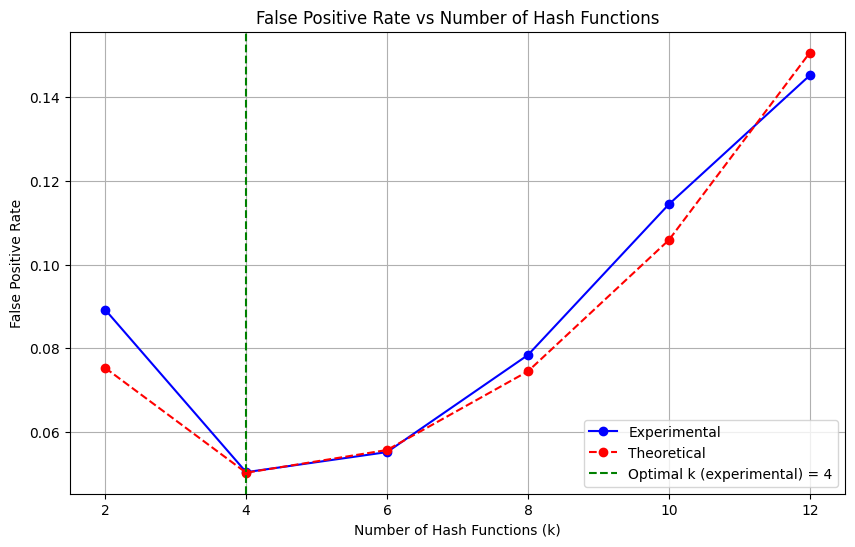

In [ ]:
k_values, fp_rates = zip(*fp_rate_results)

optimal_k = k_values[np.argmin(fp_rates)]
optimal_fp_rate = min(fp_rates)
print(f"Optimal k for the dataset: {optimal_k}")
print(f"Optimal False Positive Rate for the dataset: {optimal_fp_rate:.4f}")

theo_opt_k = theoretical_optimal_k(m, corpus_size)
theo_rates = [theoretical_fp_rate(m, corpus_size, k) for k in k_values]
theo_fp_rate = theoretical_fp_rate(m, corpus_size, theo_opt_k)
print(f"Theoretical optimal k: {theo_opt_k}")
print(f"False positive rate for theoretical optimal k: {theo_fp_rate:.4f}")

# save the optimal k and false positive rate
if run_bloom:
    with open(run_file, "a") as f:
        f.write(f"\nOptimal k for the dataset: {optimal_k}\n")
        f.write(f"Optimal False Positive Rate for the dataset: {optimal_fp_rate:.4f}\n")
        f.write(f"\nTheoretical optimal k: {theo_opt_k}\n")
        f.write(f"False positive rate for theoretical optimal k: {theo_fp_rate:.4f}\n")


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, fp_rates, 'bo-', label='Experimental')
plt.plot(k_values, theo_rates, 'ro--', label='Theoretical')

# Mark optimal k
# plt.axvline(x=opt_k, color='g', linestyle='--', label=f'Optimal k (theoretical) = {opt_k}')
# Find experimental optimal k
exp_opt_k = k_values[fp_rates.index(min(fp_rates))]
plt.axvline(x=exp_opt_k, color='g', linestyle='--', label=f'Optimal k (experimental) = {exp_opt_k}')

plt.title('False Positive Rate vs Number of Hash Functions')
plt.xlabel('Number of Hash Functions (k)')
plt.ylabel('False Positive Rate')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.savefig(save_dirs[3] + "bloom_filter_fp_rate.png", dpi=300)
plt.show()
